# EDA, Feature engineering, Model Selection
Novartis Oncology Hackathon

Author: Long Chen, Zhifan Nan

In [139]:
import pandas as pd
import re
import numpy as np
import scipy
from glob import glob
from collections import defaultdict
import csv
import pickle
import os
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA

In [8]:
pd.set_option('display.max_columns', None)

In [3]:
data = pickle.load(open('pickle files/training_corpus_task_2_updated_1012.pkl', 'rb'))

In [73]:
data.head()

,PATIENT_ID,CAPECITABINE,LETROZOLE,TAMOXIFEN CITRATE,IBRANCE,PREDNISONE,MORPHINE SULFATE,VERZENIO,ANASTROZOLE,AFINITOR,EXEMESTANE,DEXAMETHASONE,TOPIRAMATE,LAMICTAL,METHYLPREDNISOLONE DOSE P,FLUOROURACIL,KISQALI,MORPHINE SULFATE ER,HYDROMORPHONE HCL,DEXPAK 13 DAY,METHOTREXATE,FEMARA,METHYLPREDNISOLONE,LEVETIRACETAM,MEGESTROL ACETATE,IMATINIB MESYLATE,SPRYCEL,TASIGNA,LAMOTRIGINE,OXCARBAZEPINE,KEPPRA XR,LYNPARZA,PIQRAY 300MG DAILY DOSE,NEUPOGEN,CYCLOPHOSPHAMIDE,FULVESTRANT,FLUOROPLEX,DOCETAXEL,DEXAMETHASONE SODIUM PHOS,KISQALI FEMARA 600 DOSE,MERCAPTOPURINE,PROCRIT,IXEMPRA KIT,XELODA,CARBOPLATIN,HALAVEN,TECENTRIQ,FASLODEX,CISPLATIN,GEMCITABINE HCL,CODEINE SULFATE,SOLTAMOX,DEXAMETHASONE INTENSOL,DOXORUBICIN HCL,DOXORUBICIN HYDROCHLORIDE,ZOLADEX,ARIMIDEX,EFUDEX,PREDNISONE INTENSOL,AFINITOR DISPERZ,LAMOTRIGINE ER,SIROLIMUS,TOREMIFENE CITRATE,RAPAMUNE,PACLITAXEL,AROMASIN,AZATHIOPRINE,HYDROXYUREA,VENCLEXTA,DEXPAK 10 DAY,PREDNISOLONE,TALZENNA,TOPAMAX,FARESTON,TYKERB,METHOTREXATE SODIUM,VINORELBINE TARTRATE,MORPHABOND ER,KISQALI FEMARA 400 DOSE,MILLIPRED,PIQRAY 200MG DAILY DOSE,PIQRAY 250MG DAILY DOSE,TARCEVA,TROKENDI XR,ABRAXANE,LAMOTRIGINE ODT,EVEROLIMUS,TRILEPTAL,OCTREOTIDE ACETATE,CARAC,GILOTRIF,LEVETIRACETAM ER,RAYOS,TOPIRAMATE ER,REVLIMID,ONFI,TAXOTERE,NAVELBINE,LEUKINE,LUPRON DEPOT (3-MONTH),LUPRON DEPOT (1-MONTH),IRESSA,GLEEVEC,AVASTIN,CELLCEPT,PERJETA,HERCEPTIN,HYDROMORPHONE HCL ER,DEXPAK 6 DAY,ELLENCE,EPIRUBICIN HCL,EXALGO,EPOGEN,NEORAL,KISQALI FEMARA 200 DOSE,CYCLOSPORINE,LEUPROLIDE ACETATE,LAMICTAL STARTER/TAKING C,MEDROL DOSEPAK,ANDROXY,OXTELLAR XR,LUPRON DEPOT-PED (1-MONTH,SUBVENITE,BETASERON,NPLATE,MULPLETA,ELIGARD,DILAUDID,TREXALL,TEMOZOLOMIDE,ZEMA-PAK 6 DAY,CLOBAZAM,KEPPRA,EPIDIOLEX,HYQVIA,GAMMAGARD LIQUID,GAMUNEX-C,IMURAN,OXALIPLATIN,IRINOTECAN,KADIAN,CUVITRU,HYDROMORPHONE HYDROCHLORI,ARANESP ALBUMIN FREE,OPDIVO,TEMSIROLIMUS,VOTRIENT,LAMICTAL ODT,SANDIMMUNE,TRELSTAR MIXJECT,LAMICTAL XR,LAMICTAL CHEWABLE DISPERS,XALKORI,5-FLUOROURACIL,GEMZAR,MEKINIST,TOLAK,GEMCITABINE HYDROCHLORIDE,GEMCITABINE,ETOPOSIDE,JADENU,HIZENTRA,MESNA,l1_date,is_2l,l2_date,l1_drug,EARLIEST_BC,EARLIEST_SN,is_MBC,DIAG_HISTORY,EARLIEST_DIAG_DATE,LATEST_DIAG_DATE,UNIQUE_SERVICE_DATES,UNIQUE_SERVICE_DATES_NORMALIZED,1l_duration,last_drug_use,1l_unique_drug_count,1l_drug_use_time,diag_time
0,29360529,1008.0,1020.0,1080.0,63.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-10-08,True,2015-02-06,{TAM},2013-09-20 00:00:00,2018-03-20 00:00:00,True,"[(-1, C50.419, 03/25/2016), (-1, C50.419, 03/2...",2013-09-20,2019-12-27,101.0,1.346667,486.0,2019-07-10,1,46,332
1,29425424,NaN,NaN,NaN,84.0,NaN,30.0,1232.0,990.0,84.0,58.0,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-06-22,True,2017-11-17,{AL},2015-04-21 00:00:00,2015-04-28 00:00:00,True,"[(1, C79.51, 05/26/2016), (1, C77.9, 05/26/201...",2013-09-13,2019-12-22,164.0,2.1866

In [209]:
df_clean = data[['is_2l', 'l1_drug', 'is_MBC', '1l_duration', '1l_unique_drug_count', '1l_drug_use_time', 'diag_time']]
df_clean = df_clean.loc[df_clean['is_MBC'] == True].drop(columns = 'is_MBC')
df_clean.head()

,is_2l,l1_drug,1l_duration,1l_unique_drug_count,1l_drug_use_time,diag_time
0,True,{TAM},486.0,1,46,332
1,True,{AL},879.0,1,52,365
2,False,{AL},236.0,1,147,41
3,False,{LET},85.0,1,4,453
4,True,{AL},1147.0,1,72,456


In [210]:
drug_columns = ['AFI', 'AL', 'FAS', 'IBR', 'KIS', 'LET', 'TAM', 'VER', 'XEL']

for i in drug_columns:
    df_clean[i] = 0
    for j in range(len(df_clean)):
        df_clean[i].iloc[j] = 1 if i in df_clean.iloc[j, 1] else 0

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [211]:
df_clean.head()

,is_2l,l1_drug,1l_duration,1l_unique_drug_count,1l_drug_use_time,diag_time,AFI,AL,FAS,IBR,KIS,LET,TAM,VER,XEL
0,True,{TAM},486.0,1,46,332,0,0,0,0,0,0,1,0,0
1,True,{AL},879.0,1,52,365,0,1,0,0,0,0,0,0,0
2,False,{AL},236.0,1,147,41,0,1,0,0,0,0,0,0,0
3,False,{LET},85.0,1,4,453,0,0,0,0,0,1,0,0,0
4,True,{AL},1147.0,1,72,456,0,1,0,0,0,0,0,0,0


In [230]:
#df = df_clean.loc[df_clean['1l_duration'] != 0]
df = df_clean.copy()
df = df.drop(columns = ['l1_drug'])
df['diag_time'] = np.log(df['diag_time'])
df['1l_drug_use_time'] = np.log(df['1l_drug_use_time'])
df.head()

,is_2l,1l_duration,1l_unique_drug_count,1l_drug_use_time,diag_time,AFI,AL,FAS,IBR,KIS,LET,TAM,VER,XEL
0,True,486.0,1,3.828641,5.805135,0,0,0,0,0,0,1,0,0
1,True,879.0,1,3.951244,5.899897,0,1,0,0,0,0,0,0,0
2,False,236.0,1,4.990433,3.713572,0,1,0,0,0,0,0,0,0
3,False,85.0,1,1.386294,6.115892,0,0,0,0,0,1,0,0,0
4,True,1147.0,1,4.276666,6.122493,0,1,0,0,0,0,0,0,0


In [231]:
min_max_scaler = MinMaxScaler()
df.iloc[:, 1:] = min_max_scaler.fit_transform(df.iloc[:, 1:])

df['is_2l'] = df['is_2l'].astype(int)
df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
df = df.reset_index().drop(columns = 'index')

df.head()

,is_2l,1l_duration,1l_unique_drug_count,1l_drug_use_time,diag_time,AFI,AL,FAS,IBR,KIS,LET,TAM,VER,XEL
0,1,0.210572,0.333333,0.672034,0.678912,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,0.380849,0.333333,0.693554,0.691497,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.102253,0.333333,0.875961,0.401136,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.036828,0.333333,0.243334,0.720183,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1,0.496967,0.333333,0.750675,0.721060,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Model Selection

In [215]:
model_performance = []

In [223]:
def model_Kfold_auc(X, y, model):
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    kf.get_n_splits(X)

    auc = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        model.fit(X_train, y_train)
        yhat = model.predict_proba(X_test)
        auc_i = (roc_auc_score(y_test, yhat[:, 1]))    
        auc.append(auc_i)
    return np.mean(auc)

In [232]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold
X, y = df.iloc[:, 1:], df.iloc[:, 0]

In [233]:
for i in [XGBClassifier(), LogisticRegression(solver='liblinear'),  svm.SVC(kernel='rbf',probability=True), RandomForestClassifier(n_estimators=2000)]:
    model_performance.append(model_Kfold_auc(X, y, i))

In [234]:
model_performance

[0.848481832682948, 0.8104391299626912, 0.8278637483886537, 0.8373104134070324]

In [235]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Classifier(nn.Module):
    def __init__(self, n_input, n_hidden1, n_hidden2):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(n_input,n_hidden1)
        self.fc2 = nn.Linear(n_hidden1,n_hidden2)
        self.fc3 = nn.Linear(n_hidden2,1)
    
    def forward(self,x):
        x = F.dropout(F.relu(self.fc1(x)))
        x = F.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [243]:
model = Classifier(13, 50, 25)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

model.train()
auc = []
kf = KFold(n_splits=5, random_state=42, shuffle=True)
kf.get_n_splits(X)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    X_train, X_test, y_train, y_test = torch.FloatTensor(X_train.to_numpy()), torch.FloatTensor(X_test.to_numpy()), torch.FloatTensor(y_train.to_numpy()), torch.FloatTensor(y_test.to_numpy())
    
    for e in range(500):
        epoch_loss = 0
        epoch_acc = 0
        optimizer.zero_grad()

        y_pred = model(X_train)
        loss = criterion(y_pred.squeeze(), y_train)
        loss.backward()
        optimizer.step()

    model.eval()
    y_predict = model(X_test)
    test_loss = criterion(y_predict.squeeze(), y_test)
    auc_i = roc_auc_score(y_test.detach().numpy(), y_predict.detach().numpy())
    auc.append(auc_i)
    print(f'Epoch {e} | AUC: {auc}')

avg_auc = np.mean(auc)
print(f'Neural Network AUC: {avg_auc}')
model_performance.append(avg_auc)

Epoch 499 | AUC: [0.8122978295274236]
Epoch 499 | AUC: [0.8122978295274236, 0.8228648815644249]
Epoch 499 | AUC: [0.8122978295274236, 0.8228648815644249, 0.8352898573746631]
Epoch 499 | AUC: [0.8122978295274236, 0.8228648815644249, 0.8352898573746631, 0.8268838434081778]
Epoch 499 | AUC: [0.8122978295274236, 0.8228648815644249, 0.8352898573746631, 0.8268838434081778, 0.827531505427116]
Neural Network AUC: 0.8249735834603611


In [249]:
result = pd.DataFrame(model_performance, columns=['AUC score'], index = ["XGBoost", 'Logistic', 'SVM', 'Random Forest', 'Neural Network'])
result

,AUC score
XGBoost,0.848482
Logistic,0.810439
SVM,0.827864
Random Forest,0.837310
Neural Network,0.824974


Best Threshold=0.537651, G-Mean=0.770


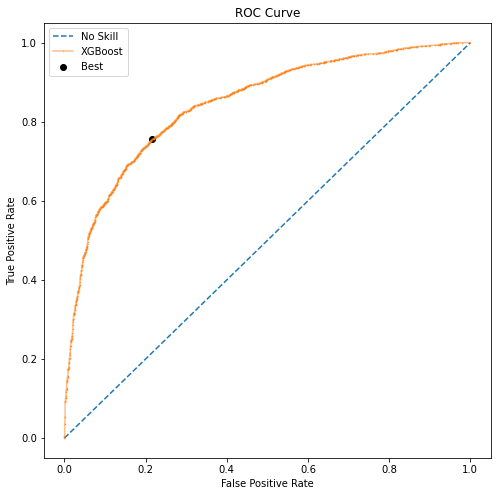

In [207]:
X, y = df.iloc[:, 1:], df.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# fit the model
model = XGBClassifier()
model.fit(X_train, y_train)
#y_hat = model.predict(X_test)
yhat= model.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, yhat[:, 1])
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.figure(figsize=(8, 8))
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='XGBoost', alpha=0.5, markersize=1)
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
# show the plot
plt.show()

In [208]:
X, y = df.iloc[:, 1:], df.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# fit the model
model = XGBClassifier()
model.fit(X_train, y_train)
#y_hat = model.predict(X_test)
y_prob= model.predict_proba(X_test)
yhat = y_prob[:, 1] >= thresholds[ix]
# evaluate predictions

cm = confusion_matrix(y_test, yhat)
print('Confusion Matrix : \n', cm)


accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))
specificity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Specificity : %.2f'% (specificity*100))
recall = recall_score(y_test, yhat)
print('Recall(Sensitivity): %.2f' % (recall*100))
precision = precision_score(y_test, yhat)
print('Precision: %2f' % (precision*100))
f1 = f1_score(y_test, yhat)
print('F1 score: %f' % (f1*100))


Confusion Matrix : 
 [[1575  431]
 [ 611 1887]]
Accuracy: 76.87
Specificity : 78.51
Recall(Sensitivity): 75.54
Precision: 81.406385
F1 score: 78.363787
